## Анализ временного ряда рождаемости девочек в Калифорнии и прогноз на месяц вперед

### Выполнил: Земнухов Вадим

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)


In [25]:
import statsmodels.api as sm
from scipy.special import inv_boxcox
from itertools import product
import warnings
import scipy.stats as sps
from statsmodels.stats.descriptivestats import sign_test

В файле `female-births.csv` содержатся данные о количестве новорожденных детей женского пола в 1959 году в Калифорнии. Проанализируем данный временной ряд и попробуем построить прогноз на месяц вперед.  

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


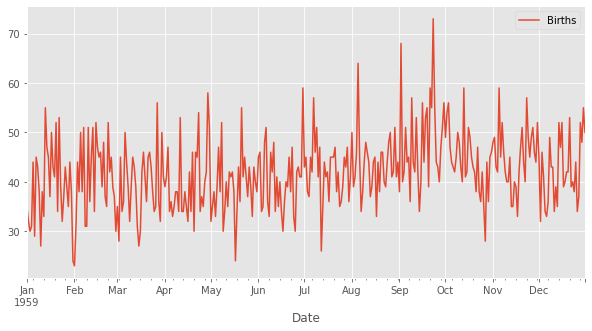

In [26]:
df = pd.read_csv('female-births.csv', index_col=['Date'], parse_dates=['Date'])
df.plot();
df.head()

На первый взгляд ряд кажется стационарным с нестабильной дисперсией. Сезонность на данном графике также явно не видно. Есть что-то похожее на периоды, но это может быть вызвано нестабильностью дисперсии. Учитывая довольно малые временные интервалы (месяцы), отображенные на графике, а также тот факт, что в данном случае речь идет о рождаемости девочек, но на мой взгляд сезонности в этом случае быть не должно. Проверим наши предположения при помощи критерия Дикки-Фулера, а также попытаемся стабилизировать дисперсию методом Бокса-Кокса.

In [27]:
df['Births'].isnull().sum()

0

In [28]:
df['Births_boxcox'], lmbd = sps.boxcox(df['Births'])
print("Оптимальный параметр преобразования Бокса-Кокса: ",lmbd)

Оптимальный параметр преобразования Бокса-Кокса:  0.28961358249748603


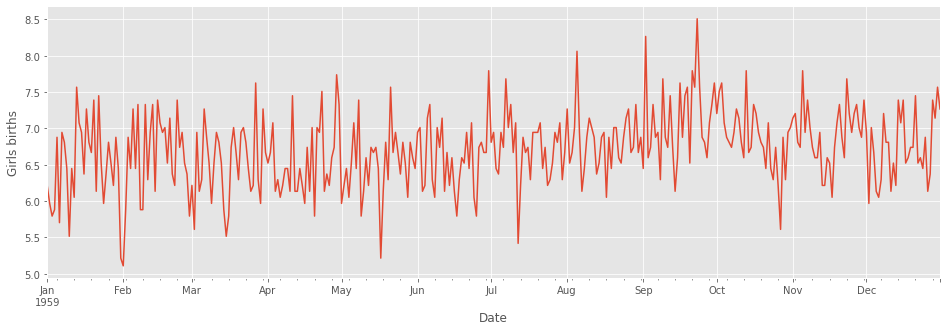

In [29]:
plt.figure(figsize=(16,5))
df['Births_boxcox'].plot()
plt.ylabel('Girls births')
plt.show()

Дисперсия стала чуть более стабильна.

<Figure size 1152x576 with 0 Axes>

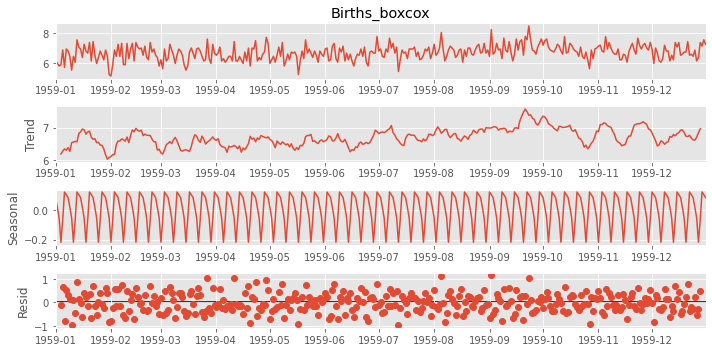

In [30]:
plt.figure(figsize=(16,8))
sm.tsa.seasonal_decompose(df['Births_boxcox']).plot()
plt.show();

Возможно, присутствует наличие тренда. Это необходимо проверить.

In [31]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",
      sm.tsa.stattools.adfuller(df['Births_boxcox'])[1])

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 0.0003719724072617037


Гипотеза о нестационарности ряда уверенно отвергается. Следовательно ряд не нужно дифференцировать.

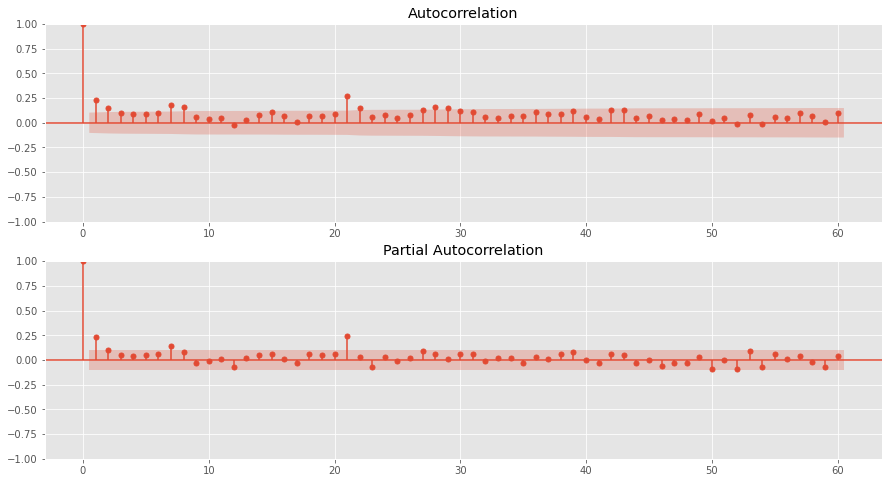

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(df['Births_boxcox'].values.squeeze(), lags=60, ax=ax1)
sm.graphics.tsa.plot_pacf(df['Births_boxcox'].values.squeeze(), lags=60, ax=ax2)

plt.show();

Согласно этим графикам, в качестве начальных значений необходимо взять: $Q=0$, $q=2$, $P=0$, $p=1$.

In [33]:
s = 30
d = 0
D = 0
ps = range(0, 1+1)
qs = range(0, 2+1)

Ps = range(0, 0+1)
Qs = range(0, 0+1)

parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

parameters_list[:10]

[(0, 0, 0, 0),
 (0, 1, 0, 0),
 (0, 2, 0, 0),
 (1, 0, 0, 0),
 (1, 1, 0, 0),
 (1, 2, 0, 0)]

In [34]:
len(parameters_list)

6

In [35]:
p=q=Q=P=1

odel=sm.tsa.statespace.SARIMAX(df['Births_boxcox'],
            order=(p, d, q), 
            seasonal_order=(P, D, Q, s))

In [36]:
odel.fit()

In [37]:
from tqdm.notebook import tqdm

results = []
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    p, q, P, Q = param
    try:
        model=sm.tsa.statespace.SARIMAX(df['Births_boxcox'],
            order=(p, d, q), 
            seasonal_order=(P, D, Q, s)).fit(disp=-1)
    
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

  0%|          | 0/6 [00:00<?, ?it/s]

In [38]:
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']

In [39]:
result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
5,"(1, 2, 0, 0)",531.607895
4,"(1, 1, 0, 0)",535.796103
3,"(1, 0, 0, 0)",715.539619
2,"(0, 2, 0, 0)",1683.937398
1,"(0, 1, 0, 0)",1987.535491


Наилучшая модель имеет параметры (1, 0, 2)х(0, 0, 0, 30).

In [40]:
best_model = sm.tsa.statespace.SARIMAX(df['Births_boxcox'], 
                                     order=(1,0,2),
                                     seasonal_order=(0,0,0,30)).fit(disp=-1)

In [41]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:          Births_boxcox   No. Observations:                  365
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -261.804
Date:                Wed, 22 Feb 2023   AIC                            531.608
Time:                        17:02:53   BIC                            547.207
Sample:                    01-01-1959   HQIC                           537.807
                         - 12-31-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   5.35e-05   1.87e+04      0.000       1.000       1.000
ma.L1         -0.8343      0.055    -15.278      0.000      -0.941      -0.727
ma.L2         -0.1242      0.055     -2.260      0.0

Чтобы убедиться, что модель хорошая проанализируем остатки. В данном summary также заметить, что критерий Льюнга-Бокса не отвергает гипотезу о независимости остатков.

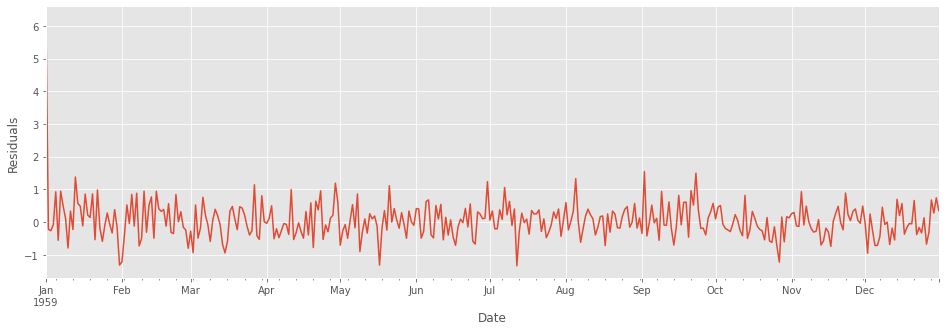

In [42]:
plt.figure(figsize=(16,5))
best_model.resid.plot()
plt.ylabel('Residuals')
plt.show()

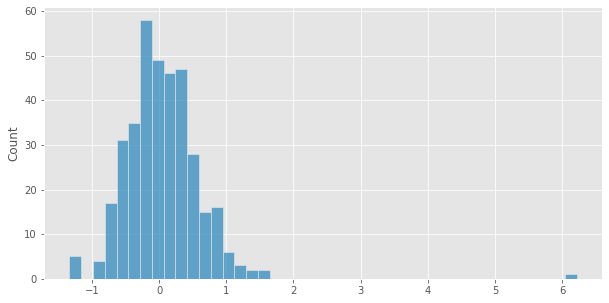

In [43]:
sns.histplot(best_model.resid);

Гистограммы остатков в целом выглядит неплохо, но имеет одно аномально большое значение, которое соответствует самому началу ряда. Возможно это связано с какой-либо аномалией.

**Несмещенность.** Проверим несмещенность с помощью критерия знаков.

In [44]:
print("Критерий знаков для остатков: pvalue =",
      sign_test(best_model.resid)[1])

Критерий знаков для остатков: pvalue = 0.9166447678112194


Гипотеза о несмещенности не отвергается.

**Стационарность.** Проверим стационарность с помщью критерия Дики-Фуллера.

In [45]:
print("Критерий Дики-Фуллера для остатков: pvalue =",
      sm.tsa.stattools.adfuller(best_model.resid)[1])

Критерий Дики-Фуллера для остатков: pvalue = 0.0


Гипотеза о нестационарности отвергается.

**Неавтокоррелированность.** Чтобы определить независимость остатков, посмотрим на график автокорреляционной функции.

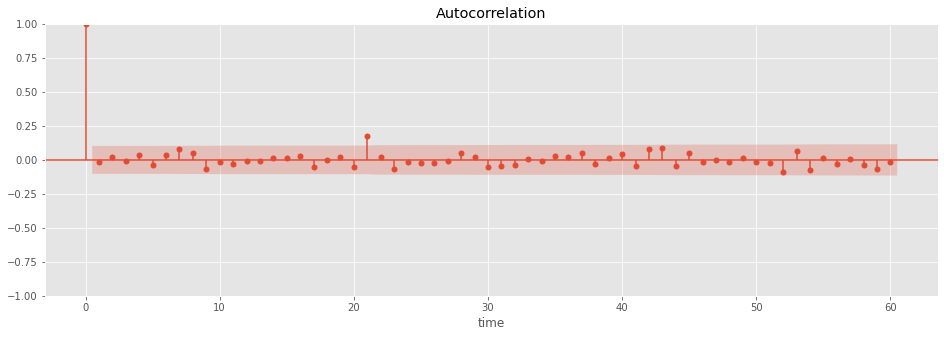

In [46]:
fig, ax = plt.subplots(figsize=(16,5))
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=60, ax=ax)
ax.set_xlabel('time')
plt.show()

По данному графику можно сказать, что остатки по большей части независимы.

In [47]:
df['model'] = inv_boxcox(best_model.fittedvalues, lmbd)

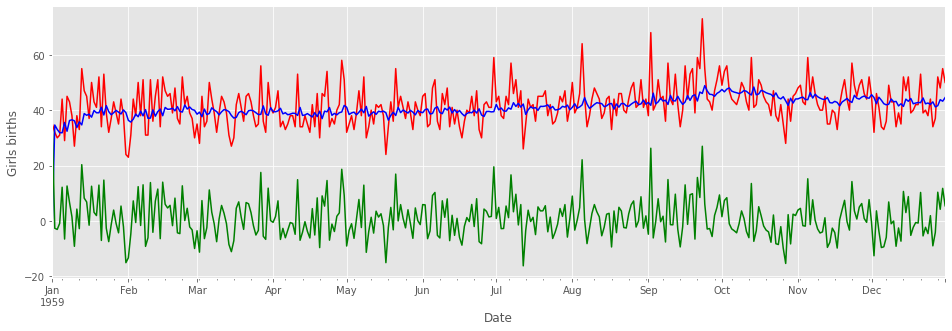

In [48]:
plt.figure(figsize=(16,5))
df['Births'].plot(color='r')
df['model'].plot(color='b')


(df['Births']-df['model']).plot(color='g')



plt.ylabel('Girls births')
plt.show();

По полученному графику видно, что наша модель не точно описывает наш временной ряд. Возможно всё-таки стоит попробовать дифференцирование.

In [49]:
df['Births_boxcox_diff'] = df['Births_boxcox'] - df['Births_boxcox'].shift(30) #сначала попробуем сделать сезонное дифференцирование (для 30 дней в месяце)

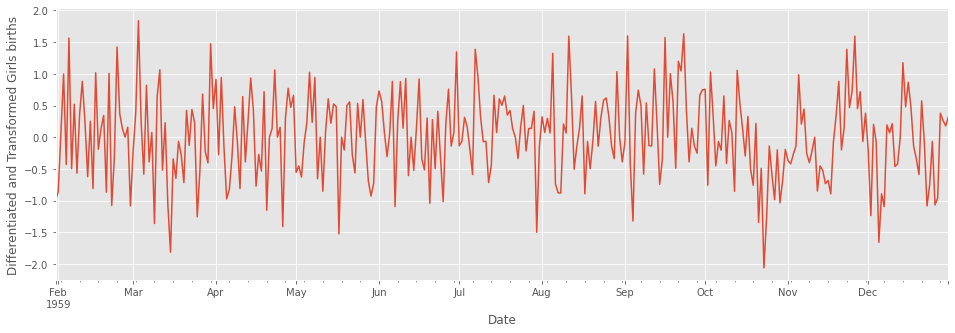

In [50]:
plt.figure(figsize=(16,5))
df['Births_boxcox_diff'][30:].plot()
plt.ylabel('Differentiated and Transformed Girls births')
plt.show()

<Figure size 1152x576 with 0 Axes>

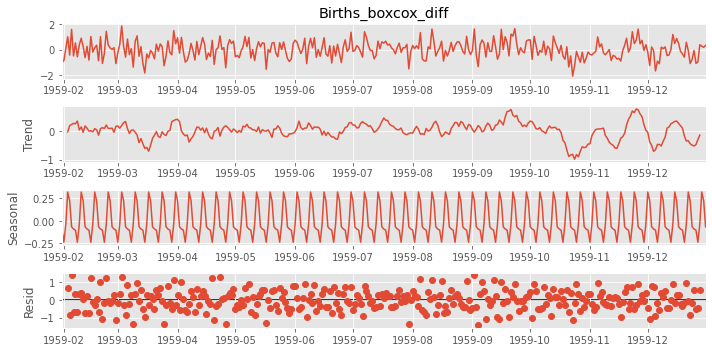

In [51]:
plt.figure(figsize=(16,8))
sm.tsa.seasonal_decompose(df['Births_boxcox_diff'][30:]).plot()
plt.show();

In [52]:
df['Births_boxcox_diff_2'] = df['Births_boxcox_diff'] - df['Births_boxcox_diff'].shift(1)

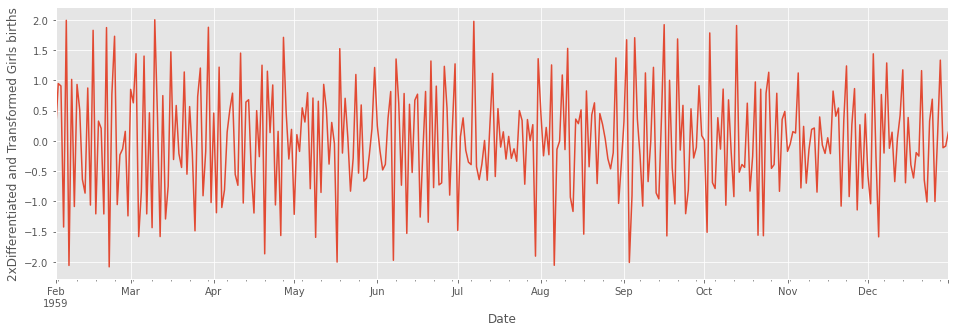

In [53]:
plt.figure(figsize=(16,5))
df['Births_boxcox_diff_2'][31:].plot()
plt.ylabel('2xDifferentiated and Transformed Girls births')
plt.show()

<Figure size 1152x576 with 0 Axes>

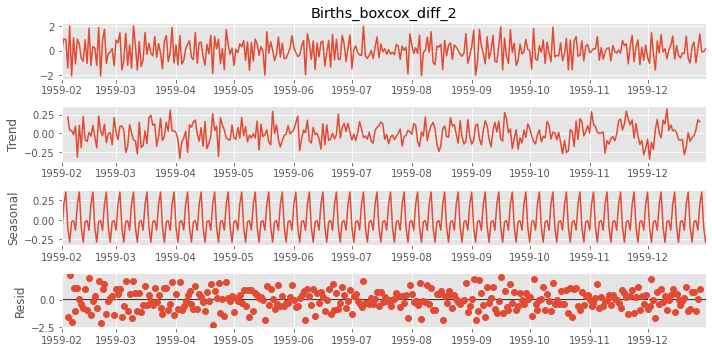

In [54]:
plt.figure(figsize=(16,8))
sm.tsa.seasonal_decompose(df['Births_boxcox_diff_2'][31:]).plot()
plt.show();

После 2 дифференцирований ряд визуально стал более стационарным. Попробуем построить модель Sarima, учитывая этот фактор.

In [55]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",
      sm.tsa.stattools.adfuller(df['Births_boxcox_diff_2'][31:])[1])

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 4.5746203608728335e-12


Как можно заметить критерий Дикки-Фулера с гораздо большей уверенностью отклоняет гипотезу о нестационарности временного ряда для дважды продифференцированного.

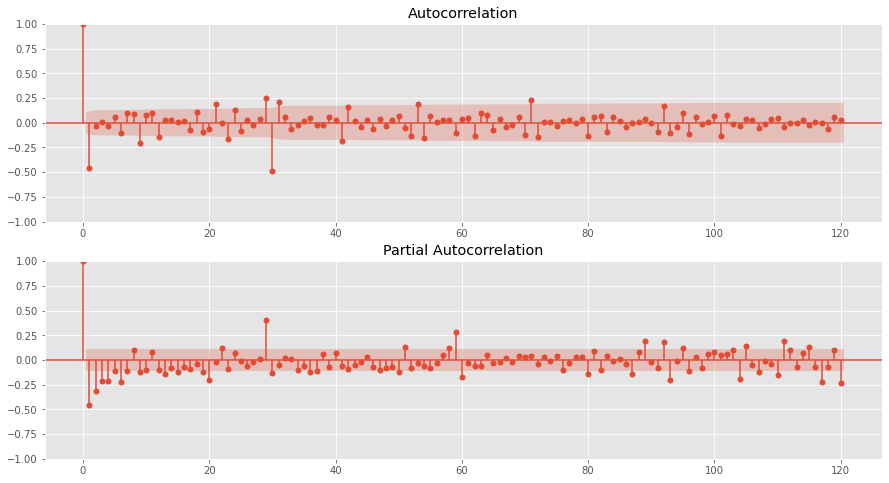

In [56]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(df['Births_boxcox_diff_2'][31:].values.squeeze(), lags=120, ax=ax1)
sm.graphics.tsa.plot_pacf(df['Births_boxcox_diff_2'][31:].values.squeeze(), lags=120, ax=ax2)

plt.show();

Согласно этим графикам, в качестве начальных значений необходимо взять: $Q=1$, $q=1$, $P=2$, $p=4$.

In [57]:
s = 30
d = 1
D = 1
ps = range(0, 4+1)
qs = range(0, 1+1)

Ps = range(0, 2+1)
Qs = range(0, 1+1)

parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

parameters_list[:10]

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1)]

In [58]:
p=q=Q=P=1

odel=sm.tsa.statespace.SARIMAX(df['Births_boxcox'],
            order=(p, d, q), 
            seasonal_order=(P, D, Q, s))

In [59]:
odel.fit()

In [60]:
results = []
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    p, q, P, Q = param
    try:
        model=sm.tsa.statespace.SARIMAX(df['Births_boxcox'],
            order=(p, d, q), 
            seasonal_order=(P, D, Q, s)).fit(disp=-1)
    
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

  0%|          | 0/60 [00:00<?, ?it/s]

In [61]:
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']

In [62]:
result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
19,"(1, 1, 0, 1)",559.338899
31,"(2, 1, 0, 1)",560.793833
21,"(1, 1, 1, 1)",560.974130
33,"(2, 1, 1, 1)",562.415311
7,"(0, 1, 0, 1)",562.640754


Наилучшая модель имеет параметры (1, 1, 1)х(0, 1, 1, 30).

In [63]:
best_model = sm.tsa.statespace.SARIMAX(df['Births_boxcox'], 
                                     order=(1,1,1),
                                     seasonal_order=(0,1,1,30)).fit(disp=-1)

In [64]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      Births_boxcox   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 30)   Log Likelihood                -275.669
Date:                            Wed, 22 Feb 2023   AIC                            559.339
Time:                                    17:05:54   BIC                            574.583
Sample:                                01-01-1959   HQIC                           565.417
                                     - 12-31-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1321      0.063      2.095      0.036       0.008       0.256
ma.L1         -0.9649      0.019   

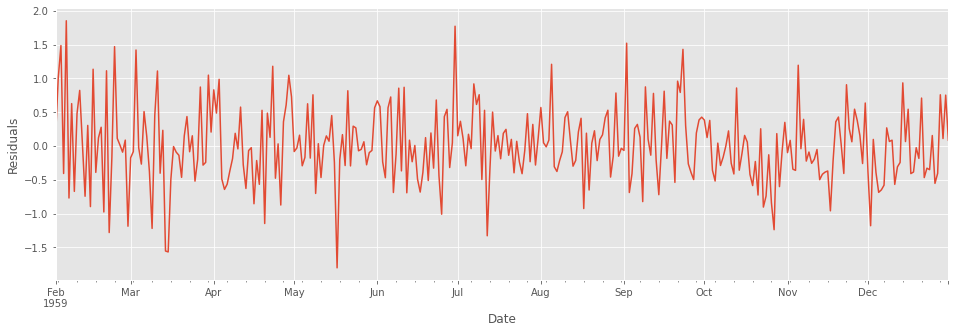

In [65]:
plt.figure(figsize=(16,5))
best_model.resid[31:].plot()
plt.ylabel('Residuals')
plt.show()

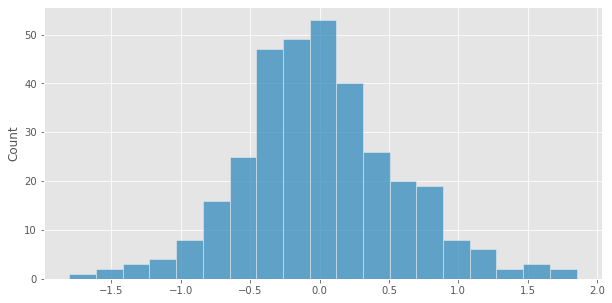

In [66]:
sns.histplot(best_model.resid[31:]);

**Несмещенность**

In [67]:
print("Критерий знаков для остатков: pvalue =",
      sign_test(best_model.resid[31:])[1])

Критерий знаков для остатков: pvalue = 0.5473094092813774


Гипотеза о несмещенности не отклоняется.

**Стационарность**

In [68]:
print("Критерий Дики-Фуллера для остатков: pvalue =",
      sm.tsa.stattools.adfuller(best_model.resid[31:])[1])

Критерий Дики-Фуллера для остатков: pvalue = 2.061036837621895e-30


Гипотеза о нестационарности отклоняется.

**Неавтокоррелированность**

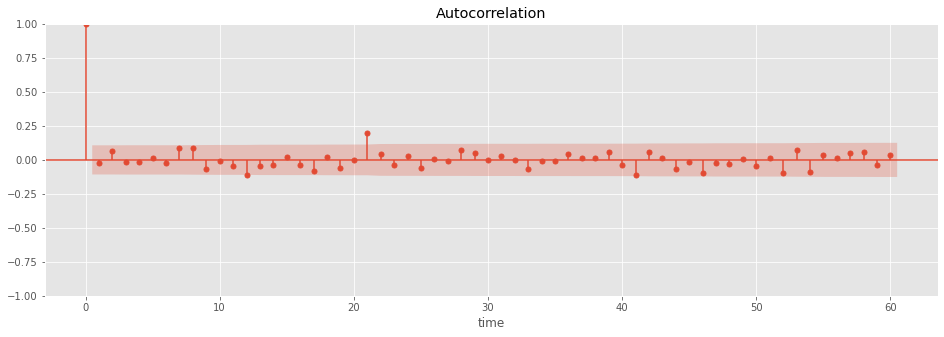

In [69]:
fig, ax = plt.subplots(figsize=(16,5))
sm.graphics.tsa.plot_acf(best_model.resid[31:].values.squeeze(), lags=60, ax=ax)
ax.set_xlabel('time')
plt.show()

In [70]:
df['model'] = inv_boxcox(best_model.fittedvalues, lmbd)

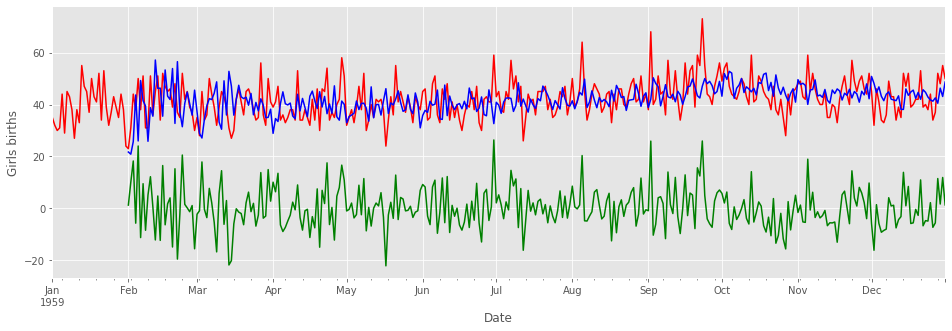

In [71]:
plt.figure(figsize=(16,5))
df['Births'].plot(color='r')
df['model'][31:].plot(color='b')


(df['Births']-df['model'][31:]).plot(color='g')



plt.ylabel('Girls births')
plt.show();

Как можно заметить построенная модель не очень точно описывает рождаемость девочек. Это может быть связано с тем, что исходный ряд имеет довольно большую дисперсию, как можно заметить из графика. При это мы знаем, что данные исходного временного ряда представлены для каждого дня, которые очень сильно колеблются в рамках месяца. Возможно, довольно сложно с высокой точностью построить подобную модель. Тем не менее мы можем заметить, что наша модель получилась несмещенной, т.к. её среднее стремится к среднему временного ряда за определенный период времени, а также у нашей модели получилась сильно меньшая дисперсия. Попробуем посторить нашу модель без преобразования Бокса-Кокса. Возможно это позволит получить более близкую модель.

In [72]:
df['Births_diff'] = df['Births'] - df['Births'].shift(30)

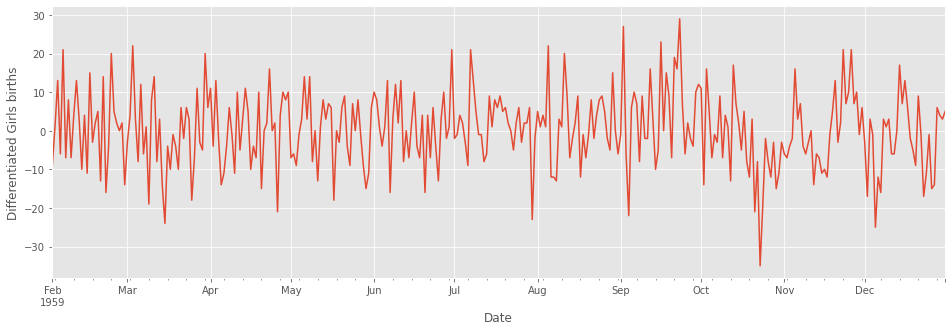

In [73]:
plt.figure(figsize=(16,5))
df['Births_diff'][31:].plot()
plt.ylabel('Differentiated Girls births')
plt.show()

In [74]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",
      sm.tsa.stattools.adfuller(df['Births_diff'][30:])[1])

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 6.655946990893192e-07


In [75]:
df['Births_diff_2'] = df['Births_diff'] - df['Births_diff'].shift(1)

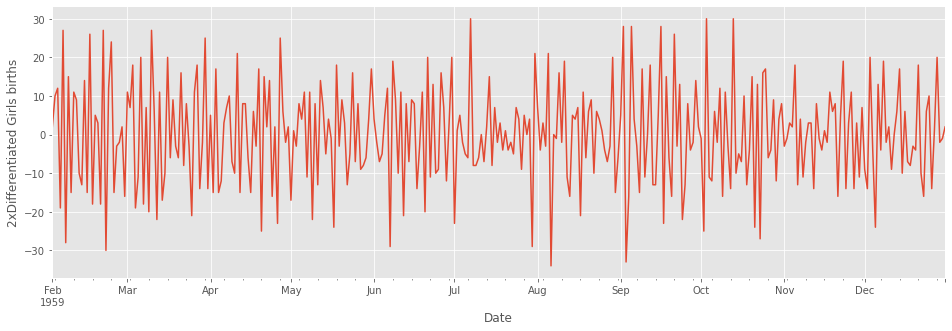

In [76]:
plt.figure(figsize=(16,5))
df['Births_diff_2'][31:].plot()
plt.ylabel('2xDifferentiated Girls births')
plt.show()

In [77]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",
      sm.tsa.stattools.adfuller(df['Births_diff'][31:])[1])

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 7.46697828720275e-07


После 2-го дифференцирования ряд стал более стационарным.

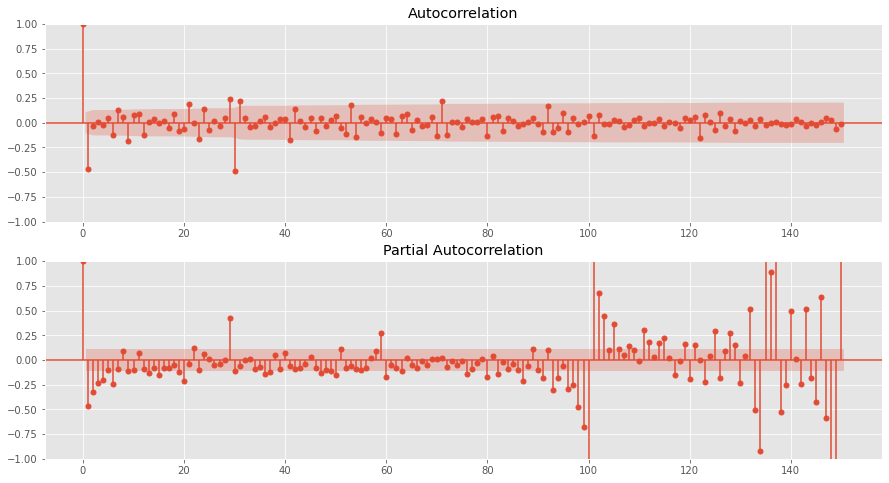

In [78]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(df['Births_diff_2'][31:].values.squeeze(), lags=150, ax=ax1)
sm.graphics.tsa.plot_pacf(df['Births_diff_2'][31:].values.squeeze(), lags=150, ax=ax2)

plt.show();

Получили очень большие значения частичной автокорреляции, что не есть хорошо. Данный ряд непригоден для обучения алгоритма Sarima. Будем для прогноза использовать модель с преобразованием Бокса-Кокса и 2-м дифференцированием.

In [79]:
best_model = sm.tsa.statespace.SARIMAX(df['Births_boxcox'], 
                                     order=(1,1,1),
                                     seasonal_order=(0,1,1,30)).fit(disp=-1)

In [80]:
df['model'] = inv_boxcox(best_model.fittedvalues, lmbd)

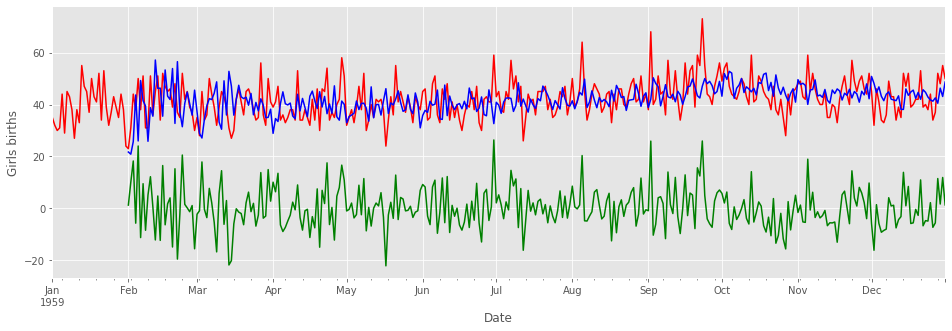

In [81]:
plt.figure(figsize=(16,5))
df['Births'].plot(color='r')
df['model'][31:].plot(color='b')


(df['Births']-df['model'][31:]).plot(color='g')


plt.ylabel('Girls births')
plt.show();

В целом мы получили модель при преобразовании Бокса-Кокса и двойном дифференцировании, предсказывающую несмещенную состоятельную оценку, однако разброс реальных данных сильно больше. При этом можно заметить, что среднее от остатков пытается сойтись к 0, однако, также очень большой разброс из-за высокой дисперсии рождаемости девочек. Попробуем построить прогноз используя эту модель.

In [82]:
df.tail(5)

,Births,Births_boxcox,model,Births_boxcox_diff,Births_boxcox_diff_2,Births_diff,Births_diff_2
Date,,,,,,,
1959-12-27,37,6.372599,42.547127,-0.956953,0.113488,-14.0,1.0
1959-12-28,52,7.390360,40.492124,0.378259,1.335212,6.0,20.0
1959-12-29,48,7.141889,46.304304,0.263649,-0.114610,4.0,-2.0
1959-12-30,55,7.567939,43.085270,0.177579,-0.086070,3.0,-1.0
1959-12-31,50,7.267890,48.652240,0.322191,0.144612,5.0,2.0


In [85]:
import datetime
from dateutil.relativedelta import relativedelta

plot_data = df[['Births','model']]

date_list = [datetime.datetime.strptime("1959-12-31", "%Y-%m-%d") + relativedelta(days=x) 
             for x in range(0,32)]
future = pd.DataFrame(index=date_list, columns= plot_data.columns)
plot_data = pd.concat([plot_data, future])

plot_data.tail()

,Births,model
1960-01-27,NaN,NaN
1960-01-28,NaN,NaN
1960-01-29,NaN,NaN
1960-01-30,NaN,NaN
1960-01-31,NaN,NaN


In [86]:
start = df.shape[0]
start

365

In [87]:
forecast = inv_boxcox(best_model.predict(start=start, end=start+31), lmbd)
forecast.index = date_list

In [88]:
plot_data.loc[date_list, 'model'] = forecast

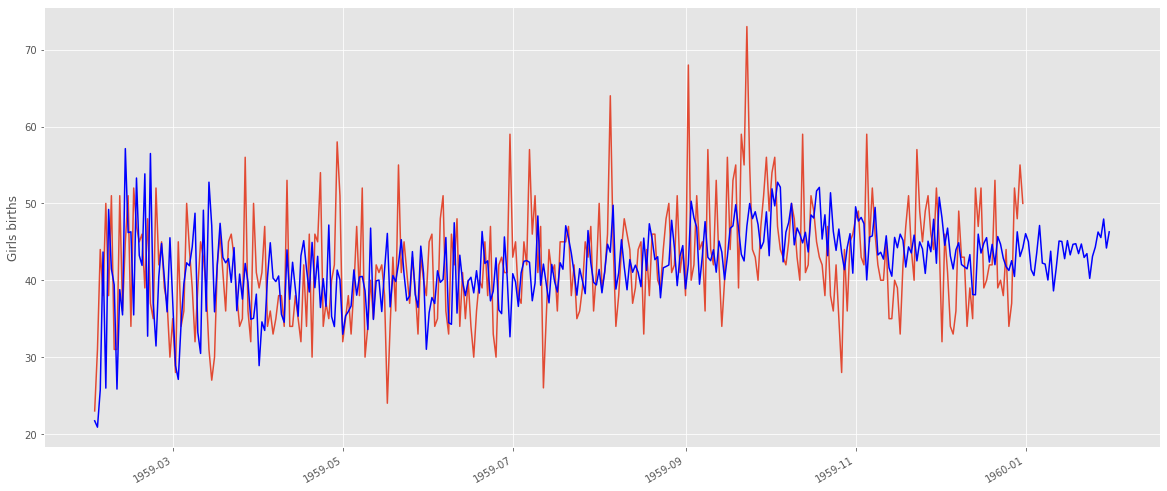

In [89]:
plt.figure(figsize=(20,9))
plot_data['Births'][31:].plot()
plot_data['model'][31:].plot(color='b')
plt.ylabel('Girls births')
plt.show();

Учитывая, что рождаемость девочек обладает большой дисперсией, можно с теми допущениями, о которых мы говорили выше, предположить, что модель получилась приемлемого качества.